In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from Data import load_data

rng = np.random.default_rng(117)

players, values, weights = load_data("Player", "PS/G▼", "SALARY")


In [2]:
# Create a population of num_teams x team_size, with random values from 0-last index
# Each individual represents a team, and each team has 15 players
def initializePopulation(num_teams, team_size, max_index):
    return rng.integers(0, max_index, (num_teams, team_size), dtype=int)

def calculateValue(individual, values):
    return np.sum(values[individual])

def calculateWeight(individual, weights):
    return np.sum(weights[individual])

# Sets the fitness to -inf if the weight exceeds the knapsack capacity, or if there are duplicate players (can't draft the same player twice)
# Otherwise, sets the fitness to the value of the team
# Since there is a limit on how many players can be in each team, don't use value to weight ratio as the fitness
def calculateFitness(individual, weights, values, capacity):
    indevidual_weight = calculateWeight(individual, weights)
    count = Counter(individual)
    fitness = calculateValue(individual, values) if indevidual_weight <= capacity else -np.inf
    for i in range(len(individual)):
        if count[individual[i]] > 1: 
            fitness = -np.inf
            break
    return fitness

# Selects the two best as the parents
def selectParents(capacity, weights, values, population):
    fitness = []
    for individual in population:
        fitness.append(calculateFitness(individual, weights, values, capacity))

    fitness = np.array(fitness)
    top_indices = np.argsort(fitness)[-2:] 
    return [population[top_indices[0]], population[top_indices[1]]]

# Generates a population of the same size as the initial population
# Selects each gene randomly from one of the parents
def generatePopulation(parents, num_teams, team_size, mutation_rate, length):
    population = np.zeros((num_teams, team_size), dtype=int)
    population[0], population[1] = parents

    for i in range(2, num_teams):
        for j in range(team_size):
            parent_choice = rng.integers(0, 2)
            population[i][j] = parents[parent_choice][j]
            
            # Mutation
            if rng.random() < mutation_rate:
                population[i][j] = rng.integers(0, length)
    return population


# Creates an initial population
# Saves the mean value for the population in each training iteration to plot
# Finds to two best as parents
# Creates a new population using the parents
# Saves only the valid solutions in the final population and returns the one with the highest value
def knapSackGenetic(capacity, weights, values, training_length, num_teams, team_size):
    max_index = len(weights) - 1
    population = initializePopulation(num_teams, team_size, max_index)

    vals = []
    for i in range(training_length):
        vals.append(np.mean([val for val in [calculateValue(ind, values) for ind in population]]))

        parents = selectParents(capacity, weights, values, population)
        population = generatePopulation(parents, num_teams, team_size, .01, max_index)
    
    valid = []
    for individual in population:
        if calculateFitness(individual, weights, values, capacity) == -np.inf: continue
        valid.append(individual)

    valid = np.array(valid)
    indices = np.argsort([val for val in [calculateValue(ind, values) for ind in valid]])
    return valid[indices[-1]], vals, valid


In [3]:
capacity = 150_000_000
training_length = 500
num_teams = 100
team_size = 15

individual, vals, valid = knapSackGenetic(capacity, weights, values, training_length, num_teams, team_size)
valid = np.unique(valid, axis=0)

individual = np.sort(individual)
print(f"Best Solution: {individual}")
print(f"Value: {calculateValue(individual, values)} | Weight: {calculateWeight(individual, weights):,}\n")

Best Solution: [ 0  1  2  3  5  6  7  8 10 11 17 18 19 39 78]
Value: 346.49999999999994 | Weight: 147,697,227



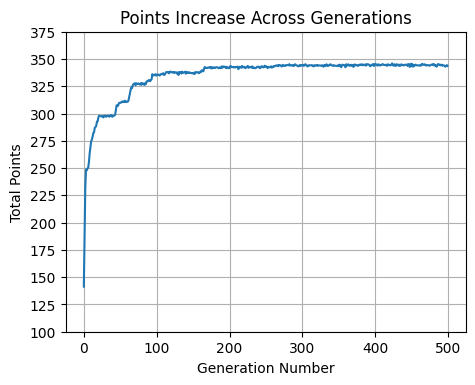

Starting Value: 141.30700000000002
Ending Value: 343.82099999999997
Max value: 345.94899999999996


In [4]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(4, 3))
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(vals)
ax.grid(True)
#ax.set_xticks(np.arange(0, len(vals) + 1, 25))
ax.set_yticks(np.arange(100, 400, 25))
ax.set_title("Points Increase Across Generations")
ax.set_ylabel("Total Points")
ax.set_xlabel("Generation Number")
plt.show()
print(f"Starting Value: {vals[0]}")
print(f"Ending Value: {vals[-1]}")
print(f"Max value: {np.max(vals)}")


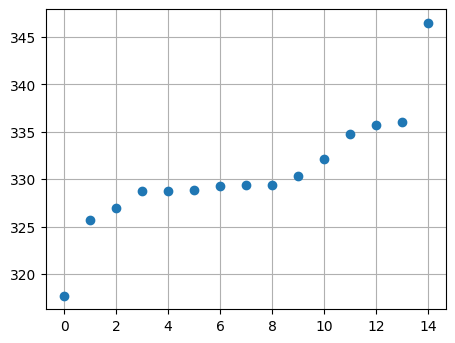

In [6]:
# Plot the last population
sums = [np.sum(values[valid[i]]) for i in range(len(valid))]
sums = np.sort(sums)
fig = plt.figure(figsize=(4, 3))
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(sums, "o")
ax.grid(True)
plt.show()